In [1]:
dataset = "purchase100"
algorithm = "TRADES"

### 1. Load Dataset

In [2]:
import numpy as np 
from art.utils import to_categorical

x = []
y = []

with open("data/dataset_purchase", "r") as f:
    for datapoint in f.readlines(): 
        split = datapoint.rstrip().split(",")
        label = int(split[0]) - 1
        x.append([int(s) for s in split[1:]])
        y.append(label)

x = np.array(x).astype(np.float32)
y = to_categorical(np.array(y), 100)

target_train_size = 10000
target_test_size = 10000
x_target_train = x[:target_train_size]
y_target_train = y[:target_train_size]
x_target_test = x[target_train_size:target_train_size+target_test_size]
y_target_test = y[target_train_size:target_train_size+target_test_size]

### 2. Define Target Model

In [3]:
from torch import nn
from torchsummary import summary
import math

def purchase_model(): 
    model = nn.Sequential(            
        nn.Linear(600, 128),
        nn.ReLU(),
        nn.Linear(128, 100)
    )
    return model

summary(purchase_model(), input_size=x_target_train[0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          76,928
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 100]          12,900
Total params: 89,828
Trainable params: 89,828
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.34
Estimated Total Size (MB): 0.35
----------------------------------------------------------------


### 3. Train Target Model

In [7]:
"""
https://raw.githubusercontent.com/yaodongyu/TRADES/master/trades.py
ICML'19 paper "Theoretically Principled Trade-off between Robustness and Accuracy"
"""
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.nn.modules.loss import _Loss

def trades_loss(model,
                loss_fn,
                x_natural,
                y,
                optimizer,
                norm=2,
                step_size=0.01,
                epsilon=0.25,
                perturb_steps=40,
                beta=6.0,
                version=None,
                device="cpu"):
    # define KL-loss
    criterion_kl = nn.KLDivLoss(size_average=False)
#     criterion_kl = nn.KLDivLoss(reduction='sum')
    model.eval()
    batch_size = len(x_natural)
    # generate adversarial example
    if norm == np.inf:
        x_adv = x_natural.detach() + 0.001 * torch.randn(x_natural.shape).to(device).detach()
        for _ in range(perturb_steps):
            x_adv.requires_grad_()
            with torch.enable_grad():
                loss_kl = criterion_kl(F.log_softmax(model(x_adv), dim=1),
                                       F.softmax(model(x_natural), dim=1))
            grad = torch.autograd.grad(loss_kl, [x_adv])[0]
            x_adv = x_adv.detach() + step_size * torch.sign(grad.detach())
            x_adv = torch.min(torch.max(x_adv, x_natural - epsilon), x_natural + epsilon)
            x_adv = torch.clamp(x_adv, 0.0, 1.0)
    elif norm == 2:
        delta = 0.001 * torch.randn(x_natural.shape).to(device).detach()
        delta = Variable(delta.data, requires_grad=True)

        # Setup optimizers
        optimizer_delta = optim.SGD([delta], lr=epsilon / perturb_steps * 2)

        for _ in range(perturb_steps):
            adv = x_natural + delta

            # optimize
            optimizer_delta.zero_grad()
            with torch.enable_grad():
                loss = (-1) * criterion_kl(F.log_softmax(model(adv), dim=1),
                                           F.softmax(model(x_natural), dim=1))
            loss.backward()
            # renorming gradient
            grad_norms = delta.grad.view(batch_size, -1).norm(p=2, dim=1)
            delta.grad.div_(grad_norms.view(-1, 1))
            # avoid nan or inf if gradient is 0
            if (grad_norms == 0).any():
                delta.grad[grad_norms == 0] = torch.randn_like(delta.grad[grad_norms == 0])
            optimizer_delta.step()

            # projection
            delta.data.add_(x_natural)
            delta.data.clamp_(0, 1).sub_(x_natural)
            delta.data.renorm_(p=2, dim=0, maxnorm=epsilon)
        x_adv = Variable(x_natural + delta, requires_grad=False)
    else:
        x_adv = torch.clamp(x_adv, 0.0, 1.0)
    model.train()

    x_adv = Variable(torch.clamp(x_adv, 0.0, 1.0), requires_grad=False)
    # zero gradient
    optimizer.zero_grad()
    # calculate robust loss
    outputs = model(x_natural)
    loss_natural = loss_fn(outputs, y)
    loss_robust = (1.0 / batch_size) * criterion_kl(F.log_softmax(model(x_adv), dim=1),
                                                    F.softmax(model(x_natural), dim=1))
    if version is not None and "sum" in version:
        loss = loss_natural + beta * batch_size * loss_robust
    else:
        loss = loss_natural + beta * loss_robust
    return outputs, loss

In [8]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from tqdm import tqdm

class PytorchDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

def train(dataloader, model, loss_fn, optimizer):
    for batch, (i_batch, o_batch) in enumerate(dataloader):
        optimizer.zero_grad()
        (_, loss) = trades_loss(model, loss_fn, i_batch, o_batch, optimizer=optimizer)
        loss.backward()
        optimizer.step()

def get_acc(model, x, y):
    _, predictions = torch.max(model(torch.from_numpy(x)), 1)
    acc = np.mean(predictions.detach().numpy() == np.argmax(y, axis=1))
    return acc

model = purchase_model()
train_dataloader = DataLoader(PytorchDataset(x_target_train, y_target_train), batch_size=64, shuffle=True)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

nb_epochs = 100
best_acc = 0
for i in tqdm(range(nb_epochs)):
    model.train()
    train(train_dataloader, model, loss_fn, optimizer)
    model.eval()
    test_acc = get_acc(model, x_target_test, y_target_test)
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), f"models/{dataset}_{algorithm}.pth")

# load best model
# model.load_state_dict(torch.load(f"models/{dataset}_{algorithm}.pth"))
model.eval()
print("Train accuracy:", get_acc(model, x_target_train, y_target_train))
print("Test accuracy:", get_acc(model, x_target_test, y_target_test))

100%|██████████| 100/100 [12:55<00:00,  7.76s/it]

Train accuracy: 1.0
Test accuracy: 0.658


### 4. Generate Adversarial Examples using HopSkipJump

In [9]:
from art.attacks.evasion import HopSkipJump
from art.estimators.classification.pytorch import PyTorchClassifier
from numpy.random import choice

art_classifier=PyTorchClassifier(
    model=model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=x_target_train[0].shape,
    nb_classes=100,
)
attack = HopSkipJump(classifier=art_classifier, norm=2, targeted=False)

train_idx = choice(len(x_target_train), 100)
y_adv_train = y_target_train[train_idx]
x_adv_train = attack.generate(x=x_target_train[train_idx], y=y_adv_train)

test_idx = choice(len(x_target_test), 100)
y_adv_test = y_target_test[test_idx]
x_adv_test = attack.generate(x=x_target_test[test_idx], y=y_adv_test)

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

### 5. Measure the Distribution of Distance to Decision Boundary

                0
count  100.000000
mean     1.125296
std      0.392481
min      0.615548
25%      0.841970
50%      1.015232
75%      1.266384
max      2.491598
                0
count  100.000000
mean     0.542456
std      0.624017
min      0.001886
25%      0.129686
50%      0.332203
75%      0.723119
max      3.166467


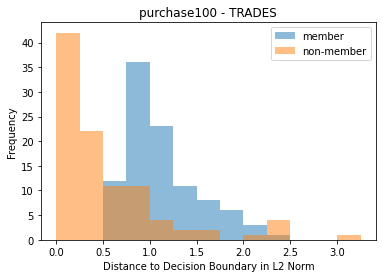

In [10]:
from matplotlib import pyplot as plt
import pandas as pd

def dist(x, x_adv):
    return np.linalg.norm(np.reshape(x_adv - x, [-1]))

dist_train = [dist(x, xa) for (x, xa) in zip(x_target_train[train_idx], x_adv_train)]
dist_test = [dist(x, xa) for (x, xa) in zip(x_target_test[test_idx], x_adv_test)]
print(pd.DataFrame(np.array(dist_train)).describe())
print(pd.DataFrame(np.array(dist_test)).describe())

bins = [0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25]

plt.hist(dist_train, bins, alpha=0.5, label='member')
plt.hist(dist_test, bins, alpha=0.5, label='non-member')
plt.legend(loc='upper right')
plt.title(f'{dataset} - {algorithm}')
plt.xlabel("Distance to Decision Boundary in L2 Norm")
plt.ylabel("Frequency")
plt.show()

### 6. Measure the Advantage of An Adversary in Label-Only Membership Inference Attacks

[0.   0.01 0.03 0.03 0.06 0.06 0.07 0.07 0.08 0.08 0.1  0.1  0.11 0.11
 0.12 0.12 0.13 0.13 0.14 0.14 0.15 0.15 0.16 0.16 0.18 0.18 0.19 0.19
 0.2  0.2  0.21 0.21 0.22 0.22 0.23 0.23 0.24 0.24 0.25 0.25 0.26 0.26
 0.28 0.28 0.29 0.29 0.31 0.31 1.  ]
[0.   0.   0.   0.01 0.01 0.13 0.13 0.18 0.18 0.22 0.22 0.34 0.34 0.37
 0.37 0.38 0.38 0.52 0.52 0.53 0.53 0.55 0.55 0.58 0.58 0.62 0.62 0.65
 0.65 0.72 0.72 0.79 0.79 0.8  0.8  0.81 0.81 0.82 0.82 0.93 0.93 0.97
 0.97 0.98 0.98 0.99 0.99 1.   1.  ]
[4.1664667e+00 3.1664670e+00 2.4969673e+00 2.4915981e+00 2.1518004e+00
 1.6317118e+00 1.6298982e+00 1.5257028e+00 1.5181261e+00 1.3847854e+00
 1.3201884e+00 1.2150100e+00 1.2124689e+00 1.1416769e+00 1.1319472e+00
 1.1226978e+00 1.0994530e+00 1.0099338e+00 1.0047457e+00 9.9927115e-01
 9.7717136e-01 9.6994108e-01 9.6984446e-01 9.6156317e-01 9.5704710e-01
 9.2280340e-01 9.2014992e-01 9.0265054e-01 9.0033948e-01 8.4834278e-01
 8.4820765e-01 8.1679451e-01 8.0038708e-01 7.9405767e-01 7.9237336e-01
 7.

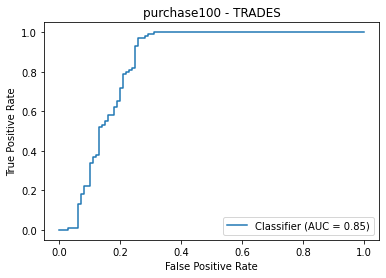

In [11]:
from matplotlib import pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, thresholds = roc_curve(
    np.concatenate((np.ones(len(dist_train)), np.zeros(len(dist_test)))),
    dist_train + dist_test
)
print(fpr)
print(tpr)
print(thresholds)

RocCurveDisplay.from_predictions(
    np.concatenate((np.ones(len(dist_train)), np.zeros(len(dist_test)))),
    dist_train + dist_test
)
plt.title(f'{dataset} - {algorithm}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

### 7. Measure the Statistical Relationship between Distance to Decision Boundary and Confidence Scores

In [12]:
from scipy.stats.stats import pearsonr
import scipy

confidence_train = [np.amax(scipy.special.softmax(p)) for p in art_classifier.predict(x_target_train[train_idx])]
confidence_test = [np.amax(scipy.special.softmax(p)) for p in art_classifier.predict(x_target_test[test_idx])]

corr, pvalue = pearsonr(confidence_train, dist_train)
print("train correlation ", corr, pvalue)
corr, pvalue = pearsonr(confidence_test, dist_test)
print("test correlation ", corr, pvalue)

train correlation  0.017373472861253698 0.8637807949523127
test correlation  0.5392093643880025 7.123629313979777e-09
